## DATA IMPORTING/CLEANING/PREPARING

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Import Libraries

import csv
import random
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch


%matplotlib inline

In [ ]:
#df = pd.read_csv('/content/gdrive/My Drive//MIE1624/metadata.csv')
df.info(verbose=True)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
# load the meta data from the CSV file and extract out fields that will be useful to our application

df = df[['title','abstract','authors','publish_time']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()
df['title'] = df['title'].str.lower()
df.head()

,title,abstract,authors,publish_time
0,clinical features of culture-proven mycoplasma...,objective: this retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04
1,nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15
2,surfactant protein-d and pulmonary host defense,surfactant protein-d (sp-d) participates in th...,"Crouch, Erika C",2000-08-25
3,role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22
4,gene expression in epithelial cells in respons...,respiratory syncytial virus (rsv) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11


In [ ]:
# Filtering to contain only papers post 2020/01/01 before 2021/04/13
# Finding all covid-19 related rows by looking up abstract/title with specific strings like 'covid'
# 171262 lines remaining

df['publish_time']= pd.to_datetime(df['publish_time'], format='%Y-%m-%d')
new_df = df[df['publish_time']>='2020-01-01']
new_df = new_df[new_df['publish_time']<='2021-04-14']
new_df = new_df[(new_df['title'].str.contains("covid-19")) | (new_df['title'].str.contains("coronavirus")) | (new_df['abstract'].str.contains("coronavirus")) | (new_df['abstract'].str.contains("covid-19"))]

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171866 entries, 4540 to 497905
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         171866 non-null  object        
 1   abstract      171866 non-null  object        
 2   authors       171866 non-null  object        
 3   publish_time  171866 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 6.6+ MB


In [ ]:
# cleaning functionality
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords

def clean_text(text):

    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove stop words
    stop = ["coronavirus", "disease", "cov", "covid"] + list(stopwords.words('english'))
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# clean text data
new_df["abstract"] = new_df["abstract"].apply(lambda x: clean_text(x))
new_df["title"] = new_df["title"].apply(lambda x: clean_text(x))

Main outcomes:
1. There are 400000+ rows with 240000+ published after the covid-19 outbreak.
2. Around 170000+ papers are discussing covid-19 related matters. We are only concerned with these articles.

## DATA visualization

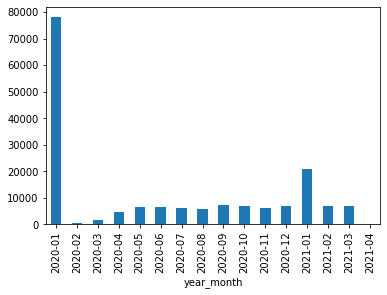

In [ ]:
# Visualizing the amount of articles published per month since the outbreak

new_df['year_month'] = pd.to_datetime(new_df['publish_time']).dt.to_period('M')
new_df.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')



In [ ]:
# word cloud for abstract/title
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

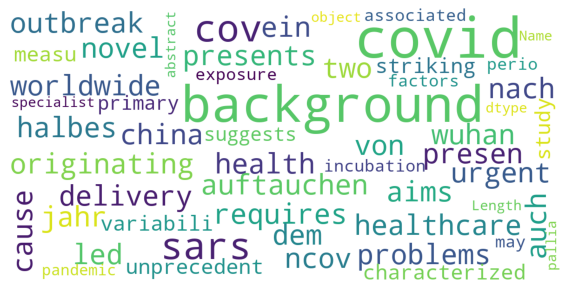

In [ ]:
show_wordcloud(new_df["abstract"])

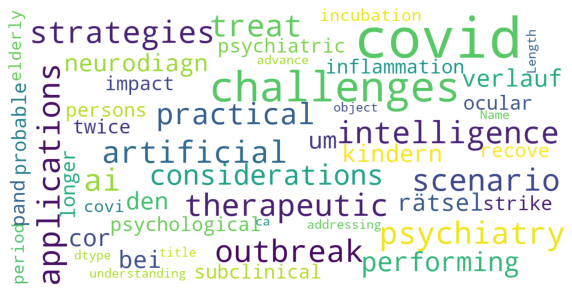

In [ ]:
show_wordcloud(new_df["title"])

Main outcomes:
1. It's surprising how fast the biomedical scientists respond to the covid-19 oubreak. There are over 70000 papers published regarding the virus immediately after the outbreak in January.

2. According to wordcloud graph, discussion revolving around the pandemic is not only limited to how the disease can be cured. There are various topics like: 1) "artificial" "intelligence"(maybe to predict infection rate or to help stop spreading?). 2)"SARS", here it might be comparing the virus to sars in hope to learn from the past. 3)"Backgound", "originating" indicates discussion about origination of the virus and so on.

3. Based on above obervations, it's clear that studying about the pandemic is emerging rapidly and will likely continue to be for quite a long period. It's also clear that those studies have wide range of interests. If the data can be organized into catogries, one can see the progress of how each different aspect of the pandemic is analyzed/learned and the information can be helpful to several parties for macro decision making. **So I decided that the model I'll implement serves to categorize those articles.**

# Everything about the model

**Reasoning behind the model choices:**

**1. Why features used are abstract/title fields only?**

   The main reason being to process and train on full-size data with essay instance included is too computationally intense/impossible for collab computer or my laptop. Second reason is that title and abstract has sufficient enough information for what I'm trying to learn.

**2. Why unsupervised method?**

   The data isn't labelled and in fact, one of the main results of the project is to label the data without actually knowing what potential labels might be. This falls into the category of clustering and most clustering methods are unsupervised.

**3. Why truncated SVD?**
   
   **Most of intuitions/methods I will be mentioning below are inspired by NLP technique "Latent Semantic Analysis".** The original plan was to train the model on limited number of features from TF-IDF transforming (for example in assignment3 I limit the number to be 10000). But it turns out that for bigger data like this, having that much features is not quite realistic as model will run well over 40 minutes to fit. Dimensionality reduction is urgently needed but a standard PCA would explode memory with such sparse matrix. After some research, I found that Truncated SVD does not cause the same problem and is commonly used in the industry to address similar matter. Therefore, TF-IDF transforming is chained to truncated SVD to construct input matrix to machine learning model.

**4. What model is used? How is it tuned?**
  
  I used **KMeans** algorithm which is a classic but powerful clustering method and it takes in hyper-parameter "k" that indicates number of clusters. Since there are no target values to evaluate the performance of models, I used **"Elbow method"** to find the most optimal k value. Evaluation is based on the sum of squared distance from the points to the cluster they are assigned to. This sum of distance gets smaller with larger k value(i.e, more clusters) and it equals zero when k is set to number of observation. However, we don't want crazy many clusters, to find optimal k is to find the right amount of clusters that yields relatively low squared error. So I tested 20 models with k value ranging from 1 to 20 and plot their corresponding squared distance. The plot is showing a not so obvious arm-like curve and the turning point/elbow point on arm is determined as optimal point. In this case, optimal k is 9.


In [ ]:
# importing bow, tfidf, k-mean from sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = CountVectorizer(analyzer = 'word', stop_words='english', max_features = 10000)

In [ ]:
new_df.head()

,title,abstract,authors,publish_time
4540,therapeutic strategies outbreak scenario treat...,novel 2019-ncov originating wuhan china presen...,"Kruse, Robert L.",2020-02-07
10752,artificial intelligence ai applications covid-...,background aims healthcare delivery requires s...,"Vaishya, Raju; Javaid, Mohd; Khan, Ibrahim Hal...",2020-04-14
10864,challenges psychiatry,covid-19 presents two urgent health problems i...,"Kelly, Brendan D.",2020-04-15
10889,practical considerations performing neurodiagn...,2019 sars-cov-2 cause covid-19 led worldwide s...,"Haines, Seline; Caccamo, Amy; Chan, Fonda; Gal...",2020-05-06
10971,covid-19 rätsel um den verlauf bei kindern cor...,auch ein halbes jahr nach dem auftauchen von s...,"Reinhardt, D.",2020-05-14


In [ ]:
# concatenating title and abstract
X_train = (new_df.title + ' ' + new_df.abstract).to_list()

In [ ]:
tfidf = TfidfVectorizer(analyzer = 'word', stop_words='english', use_idf=True, smooth_idf=True, norm=None, max_features=None)
X_train_tfidf = tfidf.fit_transform(X_train)

In [ ]:
X_train_tfidf

<171866x211991 sparse matrix of type '<class 'numpy.float64'>'
	with 16496198 stored elements in Compressed Sparse Row format>

In [ ]:
# Apply truncated SVD to reduce dimensionality.

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(X_train_tfidf)
X_new = svd.transform(X_train_tfidf)

In [ ]:
# Showing how much variance explained by SVD transforming
print(svd.explained_variance_ratio_.sum())

0.2527513727473207


In [ ]:
# Tuning for best hyper-parameter number of centers for KMeans model
Sum_of_squared_distances = []
K = range(1,20)
dictOfLabels = dict.fromkeys(K)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_new)
    dictOfLabels[k] = km.labels_
    Sum_of_squared_distances.append(km.inertia_)

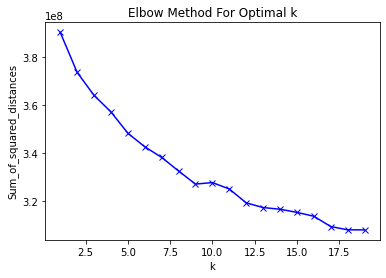

In [ ]:
# We don't have labels to verify the model's performance.
# So an alternative way of deciding number of centers: Elbow method
# We know that squared distance will decline when k gets bigger, it gets to zero
# when k = number of obersavtions.
# So I'm recording the sum of squared distance for each different k value.
# And plotting them to see if we can find an "elbow" point on a arm-like curve, that
# point would be optimal since it indicates the rate of declining is slowing down.

# Here the plot isn't that much arm-like but we can still observe that k = 9 might be an
# elbow point.
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Get the label and attach it back to df
label = dictOfLabels[9]
new_df['label'] = label.tolist()

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171866 entries, 4540 to 497905
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         171866 non-null  object        
 1   abstract      171866 non-null  object        
 2   authors       171866 non-null  object        
 3   publish_time  171866 non-null  datetime64[ns]
 4   label         171866 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 7.9+ MB


In [ ]:
# number of instances in each class
new_df['label'].round(6).value_counts()

2    102748
0     24115
5     18545
4     15486
1      7474
7      1629
6      1380
3       483
8         6
Name: label, dtype: int64

# Results and conclusion

In [ ]:
# text is cleaned again to remove commonly appeared words that do not help
# us demonstrating each category
def clean_text2(text):
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove stop words
    stop = ["coronavirus", "disease", "cov", "covid", "background","introduction","pandemic"]
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [ ]:
new_df["abstract"] = new_df["abstract"].apply(lambda x: clean_text2(x))
new_df["title"] = new_df["title"].apply(lambda x: clean_text2(x))

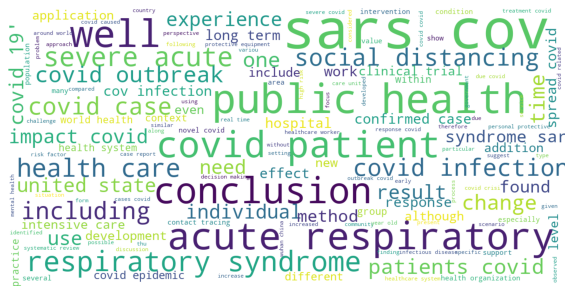

In [ ]:
show_wordcloud((new_df[new_df['label']==2]['title'] + ' ' + new_df[new_df['label']==2]['abstract']).tolist())

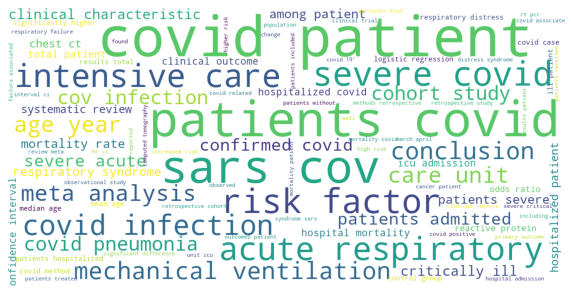

In [ ]:
# Since the numerical label isn't informative at all. We need alternative way to
# see the image of each class labelled. Therefore, wordcloud is used again.

show_wordcloud((new_df[new_df['label']==0]['title'] + ' ' + new_df[new_df['label']==0]['abstract']).tolist())

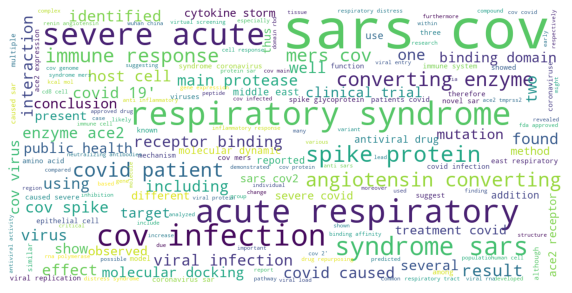

In [ ]:
show_wordcloud((new_df[new_df['label']==5]['title'] + ' ' + new_df[new_df['label']==5]['abstract']).tolist())

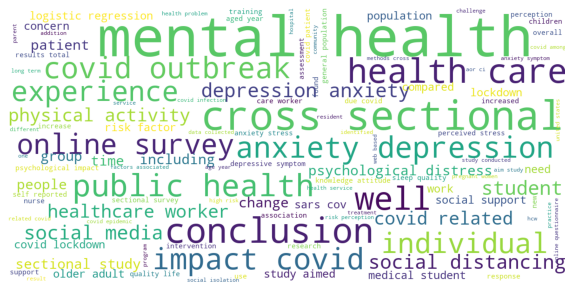

In [ ]:
show_wordcloud((new_df[new_df['label']==4]['title'] + ' ' + new_df[new_df['label']==4]['abstract']).tolist())

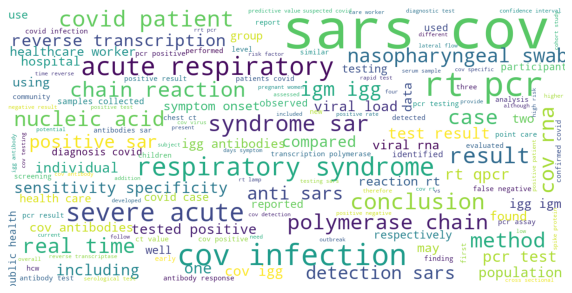

In [ ]:
show_wordcloud((new_df[new_df['label']==1]['title'] + ' ' + new_df[new_df['label']==1]['abstract']).tolist())

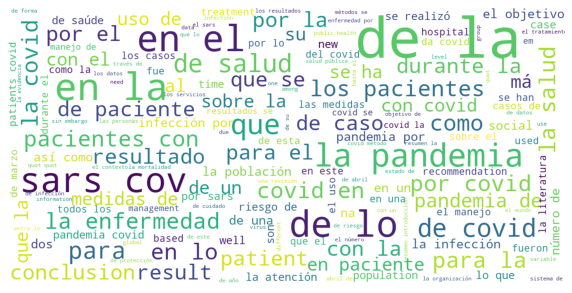

In [ ]:
show_wordcloud((new_df[new_df['label']==7]['title'] + ' ' + new_df[new_df['label']==7]['abstract']).tolist())

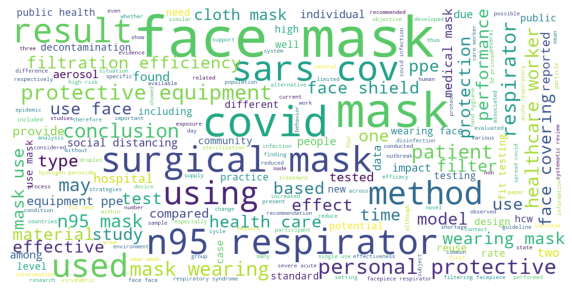

In [ ]:
show_wordcloud((new_df[new_df['label']==6]['title'] + ' ' + new_df[new_df['label']==6]['abstract']).tolist())

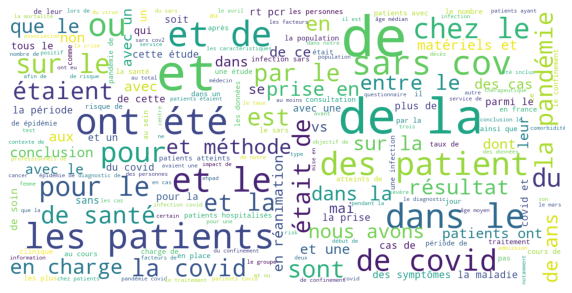

In [ ]:
show_wordcloud((new_df[new_df['label']==3]['title'] + ' ' + new_df[new_df['label']==3]['abstract']).tolist())

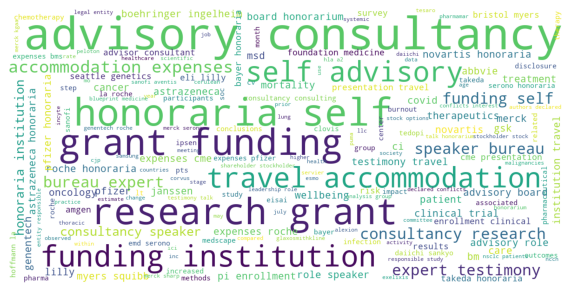

In [ ]:
show_wordcloud((new_df[new_df['label']==8]['title'] + ' ' + new_df[new_df['label']==8]['abstract']).tolist())

In [ ]:
# The following plots are intended to see how much of each different category of
# papers are published for past months.

new_df_group2 = new_df[new_df['label']==2]
new_df_group0 = new_df[new_df['label']==0]
new_df_group5 = new_df[new_df['label']==5]
new_df_group4 = new_df[new_df['label']==4]
new_df_group1 = new_df[new_df['label']==1]
new_df_group7 = new_df[new_df['label']==7]
new_df_group6 = new_df[new_df['label']==6]
new_df_group3 = new_df[new_df['label']==3]
new_df_group8 = new_df[new_df['label']==8]

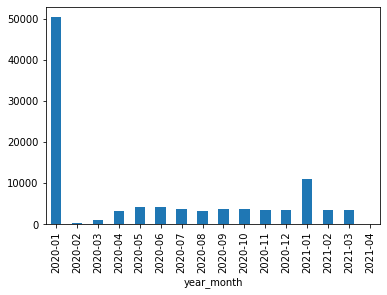

In [ ]:
new_df_group2.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')

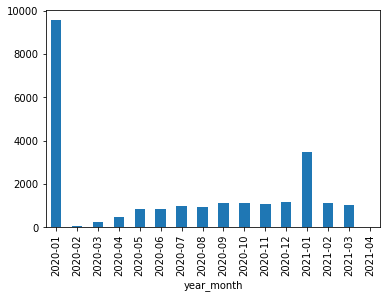

In [ ]:
new_df_group0.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')

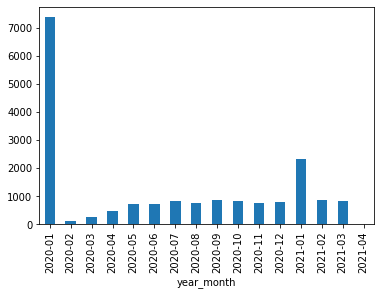

In [ ]:
new_df_group5.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')

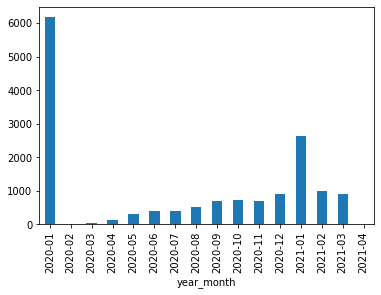

In [ ]:
new_df_group4.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')

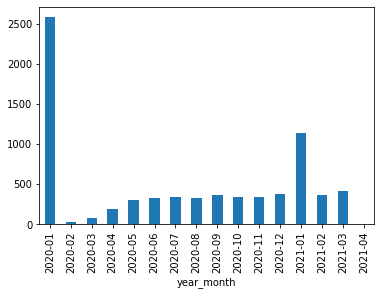

In [ ]:
new_df_group1.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')

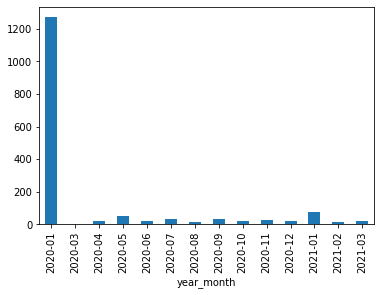

In [ ]:
new_df_group7.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')

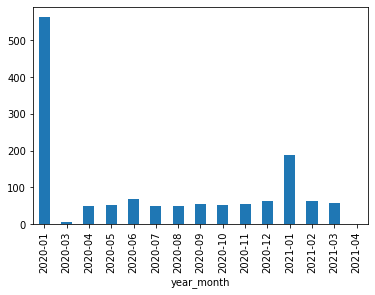

In [ ]:
new_df_group6.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')

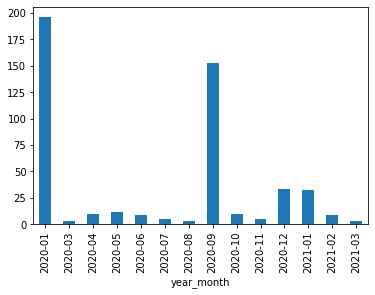

In [ ]:
new_df_group3.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')

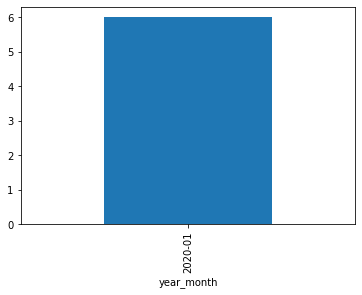

In [ ]:
new_df_group8.groupby(['year_month']).size().plot.bar(x='year_month', y='# of articles')

Main Outcomes:
1. The data is classified into 9 groups. Group 2 is the biggest with 103886 papers labelled in. Group 8 has the least amount of observations that their wordcloud visualizations is meaningless.
2. From wordcloud plotting, it seems like group 2 and 0 likely gathered papers that discuss around the properties of the virus and it's similarity to SARS. Words like syndrome, SARS, infection are mentioned frequently.

4. About 2000+ papers are in Spanish as group 7 and 3 should be groups of Spanish papers since the Spanish key words in plot. This might suggest that only minority (about 1%) of scholarly articles are produced by Spanish speaking countries.
5. For most categories, there are 2 peak time:January 2020 and January 2021 for paper publication. Only papers in group 3 are published in another peak time at September 2020.
6. Insights derived from the statistics are in pdf file.